# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [8]:
env = UnityEnvironment(file_nam
e="./Banana_Linux_NoVis/Banana.x86_64")

UnityTimeOutException: Couldn't start socket communication because worker number 0 is still in use. You may need to manually close a previously opened environment or use a different worker number.

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

NameError: name 'env' is not defined

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

NameError: name 'env' is not defined

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [3]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

NameError: name 'env' is not defined

When finished, you can close the environment.

In [17]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

---
# My Implementation:
## Agent and Replay Buffer:

**In case of a kernel restart, execute the following cell:**

In [8]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque, namedtuple
import time
import torch

#################################
#  Initialization:
#################################

# Define named tuple 'Experience'; you can use a dictionary alternatively
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


One episode consists of 300 time steps.

In [4]:
from collections import deque
import random
import os
import numpy as np
from collections import namedtuple
import time

import torch
import torch.nn.functional as F
import torch.optim as optim

from network_torch import QNetwork


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Available actions are:
# 1. forward & backward
# 2. left & right

# State is given by 7 tuples of the form [1,2,3,4,5] and two additional scalars (cf. below):
# Each of the tuples describes a ray which has been emanated along the angles: [20,90,160,45,135,70,110]
# Or in ordered sequence: [20,45,70,90,110,135,160]
# [Yellow Banana, Wall, Blue Banana, Agent, Distance]
# Ex. [0,0,1,1,0,0.34] means there is
# The last 2 numbers are the left/right turning velocity v_yaw and the forward/backward velocity v_lat of the agent: [v_yaw, v_lat]


class TorchAgent():
    def __init__(self, buffer_size, batch_size, action_size, gamma, learn_rate=0.0005):
        if not batch_size < buffer_size:
            raise Exception()

        self.state_size = 37
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.action_size = action_size
        self.gamma = gamma
        self.lr = learn_rate

        # Initialize replay buffer
        self.replay_buffer = ReplayBuffer(buffer_size, batch_size)
        # Seed the random number generator
        seed = 2#random.seed()
        # QNetwork - We choose the simple network
        self.local_net = QNetwork(self.state_size, self.action_size, seed).to(device)
        self.target_net = QNetwork(self.state_size, self.action_size, seed=3).to(device)
        self.hard_update_target_net()
        self.optimizer = optim.Adam(self.local_net.parameters(), lr=self.lr)

    # Let the agent learn from experience
    def learn(self):
        # Check if buffer is sufficiently full:
        if not self.replay_buffer.buffer_usage():
            return
        
        states, actions, rewards, next_states, dones = self.replay_buffer.sample_from_buffer()

        qs_local = self.local_net.forward(states)
        qsa_local = qs_local[ torch.arange(self.batch_size, dtype=torch.long), actions.reshape(self.batch_size) ]
        qsa_local = qsa_local.reshape( (self.batch_size, 1) )

        qs_target = self.target_net.forward(next_states)
        _, qsa_local_argmax_a = torch.max(qs_local, dim=1)
        qsa_target = qs_target[ torch.arange(self.batch_size, dtype=torch.long), qsa_local_argmax_a.reshape(self.batch_size) ]

        qsa_target = qsa_target * (1 - dones.reshape(self.batch_size))
        qsa_target = qsa_target.reshape((self.batch_size,1))
        TD_target = rewards + self.gamma * qsa_target

        loss = F.mse_loss(qsa_local, TD_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        """
        Q_targets_next = self.target_net(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.local_net(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        """

        self.soft_update_target_net()


    # Take action according to epsilon-greedy-policy:
    def action(self, state, epsilon=0.02):
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local_net.eval()
        with torch.no_grad():
            action_values = self.local_net.forward(state)
        self.local_net.train()

        if random.random() < epsilon:
            return random.randrange(0, self.action_size)
        else:
            #print(action_values.cpu().data.numpy())
            return np.argmax(action_values.cpu().data.numpy())

    def random_action(self):
        return random.randrange(0, self.action_size)

    # Copy weights from short-term model to long-term model (soft update)
    def soft_update_target_net(self, tau=0.001):
        for t, l in zip(self.target_net.parameters(), self.local_net.parameters() ):
            t.data.copy_( (1-tau)*t.data + tau*l.data )

    def hard_update_target_net(self):
        self.soft_update_target_net( tau=1.0 )

    def load_weights(self, path):
        filepath = os.path.join(path, "ddqn_weights_latest.pth")
        print("Loading network weights from", filepath)
        self.local_net.load_state_dict(torch.load(filepath, map_location=lambda storage, loc: storage))
        self.hard_update_target_net()

    def save_weights(self, path):
        filepath = os.path.join(path, "ddqn_weights_latest.pth")
        print("Saving target network weights to", filepath)
        torch.save(self.target_net.state_dict(), filepath) 


class ReplayBuffer():
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.replay_buffer = deque(maxlen=self.buffer_size)

    # Insert experience into memory
    def insert_into_buffer(self, experience):
        self.replay_buffer.append(experience)

    # Randomly sample memory
    def sample_from_buffer(self):
        # Sample experience batch from experience buffer
        batch = random.sample(self.replay_buffer, self.batch_size)
        
        # Reorder experience batch such that we have a batch of states, a batch of actions, a batch of rewards, etc.
        state = torch.from_numpy( np.vstack( [exp.state for exp in batch if exp is not None] )).float().to(device)
        action = torch.from_numpy( np.vstack( [exp.action for exp in batch if exp is not None] )).long().to(device)
        reward = torch.from_numpy( np.vstack( [exp.reward for exp in batch if exp is not None] )).float().to(device)
        state_next = torch.from_numpy( np.vstack( [exp.next_state for exp in batch if exp is not None] ) ).float().to(device)
        done = torch.from_numpy( np.vstack( [exp.done for exp in batch if exp is not None] ).astype(np.uint8) ).float().to(device)

        return state, action, reward, state_next, done

    # Get length of memory
    def buffer_usage(self):
        return len(self.replay_buffer) > self.batch_size


## Network Definition

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, units_fc1 = 64, units_fc2 = 64):
        super(QNetwork, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, units_fc1)
        self.fc2 = nn.Linear(units_fc1, units_fc2)
        self.fc3 = nn.Linear(units_fc2, action_size)

    def forward(self, state):
        x = F.relu( self.fc1(state) )
        x = F.relu( self.fc2(x) )
        action = self.fc3( x )
        return action

## Main Training Loop

In [6]:
from agent_torch import TorchAgent
agent = TorchAgent(buffer_size=100000, batch_size=64, action_size=4, gamma=0.99)

#agent.load_weights("./checkpoints")

def training(n_episodes=500):
    eps = 1.
    eps_end = 0.02
    eps_decay = 0.995
    learning_period = 4

    score_list = []   # Score is NOT the discounted reward but the final 'Banana Score' of the game
    score_trailing_list = deque(maxlen=100)
    score_trailing_avg_list = []

    for episode in range(n_episodes):
        ticks = 0
        score = 0

        env_info = env.reset(train_mode=True)[brain_name]  # Reset the environment
        state = env_info.vector_observations[0]            # Get the current state
        
        start = time.time()
        while True:
            # Select action according to policy:
            action = agent.action(state, epsilon=eps)
            #print("[Episode {}, Time {}] Action taken: {}".format(episode, time, action))
            # Take action and record the reward and the successive state
            env_info = env.step(action)[brain_name]

            reward = env_info.rewards[0]
            next_state = env_info.vector_observations[0]
            done = env_info.local_done[0]

            # Add experience to the agent's replay buffer:
            exp = Experience(state, action, reward, next_state, done)
            agent.replay_buffer.insert_into_buffer( exp )

            if ticks % learning_period == 0:
                agent.learn()

            score += reward
            state = next_state

            if done is True:
                break

            ticks += 1

        end = time.time()

        score_list.append(score)
        score_trailing_list.append(score)

        score_trailing_avg = np.mean(score_trailing_list)
        score_trailing_avg_list.append(score_trailing_avg)
        
        print("***********************************************")
        print("Score of episode {}: {}".format(episode, score))
        print("Trailing avg. score: {:.2f}".format(score_trailing_avg))
        print("Greedy epsilon used: {:.2f}".format(eps))
        print("Time consumed: {:.2f} s".format(end-start))
        print("***********************************************")

        if score_trailing_avg >= 13.0:
            print("===============================================")
            print("Challenge solved at episode {}".format(episode))
            print("===============================================")

        eps = max(eps*eps_decay, eps_end)
        episode += 1

        agent.save_weights("./checkpoints_torch")

    return score_list, score_trailing_avg_list

In [9]:
score_list, score_trailing_avg_list = training(2000)

llenge solved at episode 1950
Saving target network weights to ./checkpoints_torch/ddqn_weights_latest.pth
***********************************************
Score of episode 1951: 17.0
Trailing avg. score: 15.74
Greedy epsilon used: 0.02
Time consumed: 1.05 s
***********************************************
Challenge solved at episode 1951
Saving target network weights to ./checkpoints_torch/ddqn_weights_latest.pth
***********************************************
Score of episode 1952: 18.0
Trailing avg. score: 15.73
Greedy epsilon used: 0.02
Time consumed: 1.02 s
***********************************************
Challenge solved at episode 1952
Saving target network weights to ./checkpoints_torch/ddqn_weights_latest.pth
***********************************************
Score of episode 1953: 15.0
Trailing avg. score: 15.70
Greedy epsilon used: 0.02
Time consumed: 1.00 s
***********************************************
Challenge solved at episode 1953
Saving target network weights to ./checkpoi

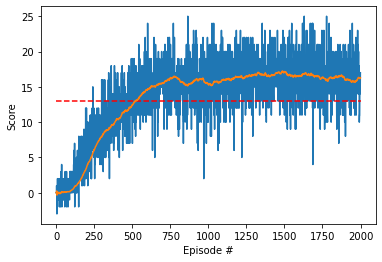

In [10]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hlines(13, 0, len(score_list), colors='red', linestyles='dashed', label='12 pts', zorder=15)
plt.plot(np.arange(len(score_list)), score_list, zorder=5)
plt.plot(np.arange(len(score_list)), score_trailing_avg_list, zorder=20)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [1]:
env.close()

NameError: name 'env' is not defined